# 3 Sampling the Imaginary


Lots of books on Bayesian statistics introduce posterior inference by using a medical testing scenario. To repeat the structure of common examples, suppose there is a blood test that correctly detects vampirism 95% of the time. In more precise and mathematical notation, $Pr(positive test result|vampire) = 0.95$. It’s a very accurate test, nearly always catching real vampires. It also make mistakes, though, in the form of false positives. One percent of the time, it incorrectly diagnoses normal people as vampires, $Pr(positive test result|mortal) = 0.01$. The final bit of information we are told is that vampires are rather rare, being only 0.1% of the population, implying $Pr(vampire) = 0.001$. Suppose now that someone tests positive for vampirism. What’s the probability that he or she is a bloodsucking immortal? 

The correct approach is just to use Bayes’ theorem to invert the probability, to compute $Pr(vampire|positive)$. The calculation can be presented as:
$$
Pr(vampire|positive) = \frac{Pr(positive|vampire)Pr(vampire)}{Pr(positive)} 
$$
where $Pr(positive)$ is the average probability of a positive test result, that is, 
$$Pr(positive) = Pr(positive|vampire) Pr(vampire) \\+ Pr(positive|mortal) (1 − Pr(vampire))$$

Performing the calculation in Python: 

In [2]:
# first define the beyes' theorem in function 
def bayes_theorem_binary(p_event:float, p_postive_event:float, p_positive_non_event:float)->float:
    '''
    Baye's theorem function when condition is binary
    ```math 
    P(event|positive) = \frac{P(positive|event)P(event)}{P(positive|event)P(event) + P(positive|not event)P(not event)}
    ``` 
    Args:
        p_event: float, P(event)
        p_postive_event: float, P(positive|event)
        p_positive_non_event: float, P(positive|not event)
    
    Return:
        float
    '''
    p_positive = p_postive_event * p_event + p_positive_non_event * (1-p_event)
    p_event_cond_on_positive = (p_postive_event * p_event)/p_positive

    return p_event_cond_on_positive

In [3]:
pr_positive_vampire = .95  # given blood test to be positive, probability of a vampire
pr_positive_mortal = .01   # given blood test to be positive, probability of a mortal
pr_vampire = .001          # in general, probability of a vampire

bayes_theorem_binary(pr_vampire, pr_positive_vampire, pr_positive_mortal)

0.08683729433272395

**A frequency format or natural frequencies description**  
But I don’t like these examples, for two reasons. First, there’s nothing uniquely “Bayesian” about them. Remember: __Bayesian inference is distinguished by a broad view of probability, not by the use of Bayes’ theorem__. Since all of the probabilities I provided above reference frequencies of events, rather than theoretical parameters, all major statistical philosophies would agree to use Bayes’ theorem in this case. Second, and more important to our work in this chapter, these examples make Bayesian inference seem much harder than it has to be. Few people find it easy to remember which number goes where, probably because they never grasp the logic of the procedure. It’s just a formula that descends from the sky. If you are confused, it is only because you are trying to understand. 

There is a way to present the same problem that does make it more intuitive, however. Suppose that instead of reporting probabilities, as before, I tell you the following: 

-   (1) In a population of 100,000 people, 100 of them are vampires.   
-   (2) Of the 100 who are vampires, 95 of them will test positive for vampirism.  
-   (3) Of the 99,900 mortals, 999 of them will test positive for vampirism. 

Now tell me, if we test all 100,000 people, what proportion of those who test positive for vampirism actually are vampires? Many people, although certainly not all people, find this presentation a lot easier.50 Now we can just count up the number of people who test positive: 95 + 999 = 1094. Out of these 1094 positive tests, 95 of them are real vampires, so that implies: $Pr(vampire|positive) = \frac{95}{1094} ≈ 0.087$ It’s exactly the same answer as before, but without a seemingly arbitrary rule.

## 3.1 Sampling from a grid-approximate posterior
Before beginning to work with samples, we need to generate them. Here’s a reminder for how to compute the posterior for the globe tossing model, using grid approximation. Remember, the posterior here means the probability of $p$ conditional on the data.

In [95]:

from functools import reduce

def factorial(x):
    if x in [0,1]:
        return 1
    return reduce(lambda x,y: x*y, [i for i in range(1,x+1)])

class Binominal:
    def __init__(self, prob: float= None, trails: int = None):
        self.prob = prob
        self.trails = trails
        pass

    def probability(self, x):
        p = factorial(self.trails)/(factorial(self.trails-x)*factorial(x))
        p *= (self.prob**x * (1-self.prob)**(self.trails - x))

        return p
    

In [5]:
import numpy as np 

# In the text book
# p_grid <-seq( from=0 , to=1 , length.out=1000 ) 
# means a sequence of 1000 number with identical interval from 0 to 1
p_grid = np.array([1/999*i for i in range(1000)])
prob_p = np.ones(1000)

prob_data = Binominal(p_grid,9).probability(6)
posterior = prob_data * prob_p 
posterior = posterior/posterior.sum()

print(f"prob_data, {prob_data[:10]}")
print(f"posterior, {posterior[:10]}")

prob_data, [0.00000000e+00 8.42522516e-17 5.37595149e-15 6.10513730e-14
 3.41994469e-13 1.30067583e-12 3.87208730e-12 9.73448877e-12
 2.16247342e-11 4.37069531e-11]
posterior, [0.00000000e+00 8.43365882e-19 5.38133282e-17 6.11124855e-16
 3.42336806e-15 1.30197781e-14 3.87596326e-14 9.74423301e-14
 2.16463805e-13 4.37507038e-13]


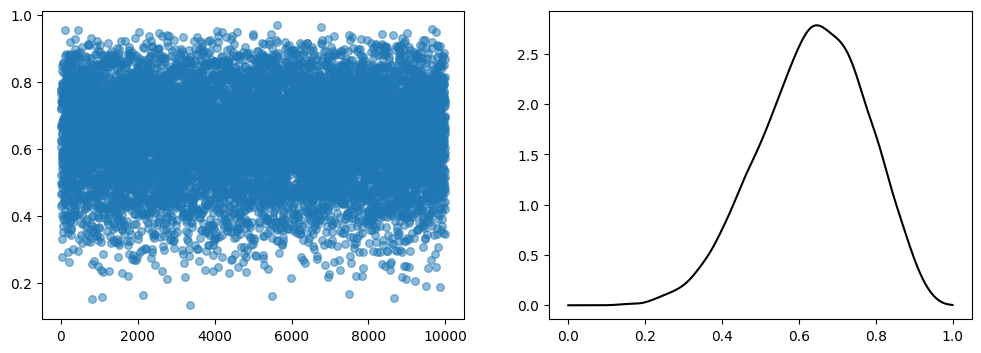

In [9]:
import random 
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

samples = np.array(random.choices(p_grid, weights =posterior, k = 10000))
kernel = gaussian_kde(samples,)


fig, axes = plt.subplots(1,2, figsize = (12,4))
axes[0].scatter(range(len(samples)), samples, s = 30, alpha=.5)
axes[1].plot(p_grid, kernel.pdf(p_grid), c = 'k')

fig.show()

## 3.2 Sampling to summarize
Once your model produces a posterior distribution, the model’s work is done. But your work has just begun. It is necessary to summarize and interpret the posterior distribution. The author introduce 3 common summary tasks:
-   (1) intervals of defined boundaries
-   (2) questions about intervals of defined probability mass
-   (3) questions about point estimates.

### 3.2.1 Intervals of defined boundaries

In [10]:
print(sum(posterior[p_grid<0.5]))
print(sum(np.array(samples) < 0.5) / 1e4)
print(sum( (samples > 0.5) & (samples < 0.75) ) / 1e4)

0.17187458902022879
0.1718
0.6116


### 3.2.2. Intervals of defined mass.

use `numpy.quantile`

```python 
>>> print(np.quantile.__doc__)
    Compute the q-th quantile of the data along the specified axis.

    .. versionadded:: 1.15.0

    Parameters
    ----------
    a : array_like of real numbers
        Input array or object that can be converted to an array.
    q : array_like of float
        Probability or sequence of probabilities for the quantiles to compute.
        Values must be between 0 and 1 inclusive.
    axis : {int, tuple of int, None}, optional
        Axis or axes along which the quantiles are computed. The default is
        to compute the quantile(s) along a flattened version of the array.
    out : ndarray, optional
        Alternative output array in which to place the result. It must have
        the same shape and buffer length as the expected output, but the
        type (of the output) will be cast if necessary.
    overwrite_input : bool, optional
        If True, then allow the input array `a` to be modified by
        intermediate calculations, to save memory. In this case, the
        contents of the input `a` after this function completes is
        undefined.
    method : str, optional
...
       "Sample quantiles in statistical packages,"
       The American Statistician, 50(4), pp. 361-365, 1996
```

In [171]:
print(np.quantile(samples, 0.8))
print(np.quantile(samples, [0.1, 0.9]))

0.7589589589589597
[0.44544545 0.81081081]


In [89]:
# we can define our pi and hpdi fucntion 
def pi(samples: np.ndarray, alpha: float):
    '''calculate posterior interval'''
    lb,ub =  np.quantile(samples, [alpha/2, 1-alpha/2])
    return lb, ub

def hpdi(samples: np.ndarray, alpha: float, prob_intvl:float = 1e-4):
    '''search the highest posterior density interval'''
    lb_prob = alpha/2
    ub_prob = lb_prob+1-alpha 
    min_d_boundaries = 1
    lb_hpdi, ub_hpdi = None, None
    while ub_prob <1:
        lb = np.quantile(samples, lb_prob)
        ub = np.quantile(samples, ub_prob)
        d_boundaries = ub - lb
        
        if min_d_boundaries > d_boundaries:
            min_d_boundaries = d_boundaries
            lb_hpdi, ub_hpdi = lb, ub 
        
        lb_prob += prob_intvl
        ub_prob = lb_prob+1-alpha 
        
    return lb_hpdi, ub_hpdi

def plot_interval(samples, lb, ub, ax = None, **kwargs):
    if not ax:    
        fig, ax = plt.subplots(**kwargs)    
    kernel = gaussian_kde(samples)
    ax.plot(p_grid, kernel.pdf(p_grid), c = 'k')
    x = np.linspace(start=lb, stop=ub, num=100)
    ax.fill_between(x, kernel.pdf(x))
    ax.set_ylim(0)
    # ax.text(ub, 0, f'{np.round(ub,3)}')
    # ax.text(lb, 0, f'{np.round(lb,3)}')
    ax.axvline(x = ub, ymax= kernel.pdf(ub)/ax.get_ylim()[1] , ls = '--', c = 'k',alpha = .9)
    ax.axvline(x = lb, ymax= kernel.pdf(lb)/ax.get_ylim()[1], ls = '--', c = 'k',alpha = .9)
    
    

Text(0.5, 1.0, 'alpha = 1%')

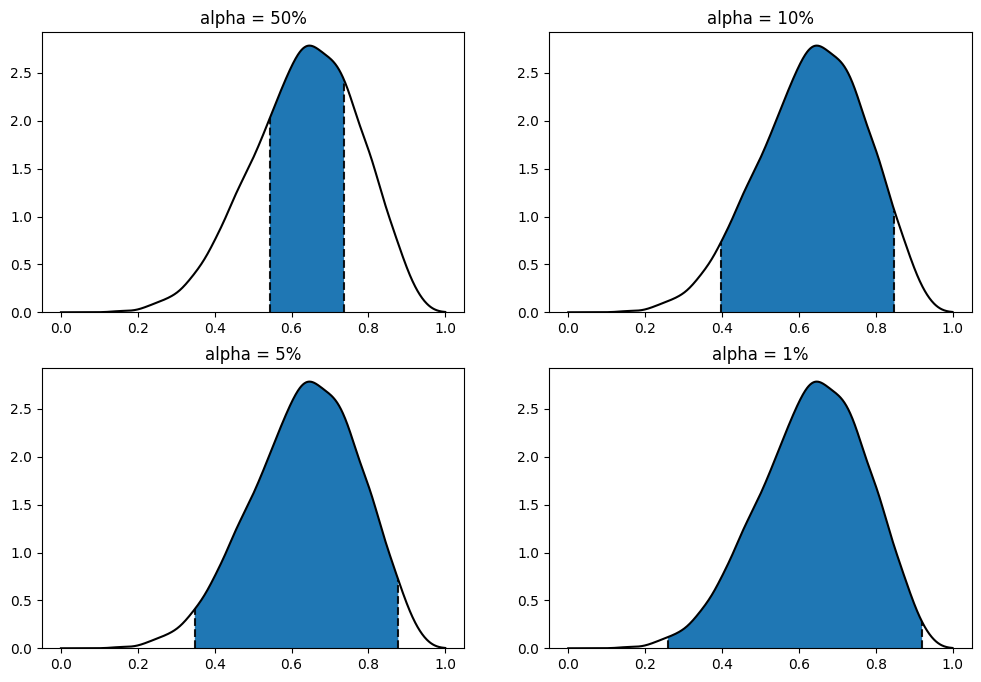

In [90]:
fig, axes = plt.subplots(2,2, figsize = (12,8))
plot_interval(samples,*pi(samples, .5),ax = axes[0][0])
plot_interval(samples,*pi(samples, .1),ax = axes[0][1])
plot_interval(samples,*pi(samples, .05),ax = axes[1][0])
plot_interval(samples,*pi(samples, .01),ax = axes[1][1])

axes[0][0].set_title('alpha = 50%')
axes[0][1].set_title('alpha = 10%')
axes[1][0].set_title('alpha = 5%')
axes[1][1].set_title('alpha = 1%')

Text(0.5, 1.0, 'alpha = 1%')

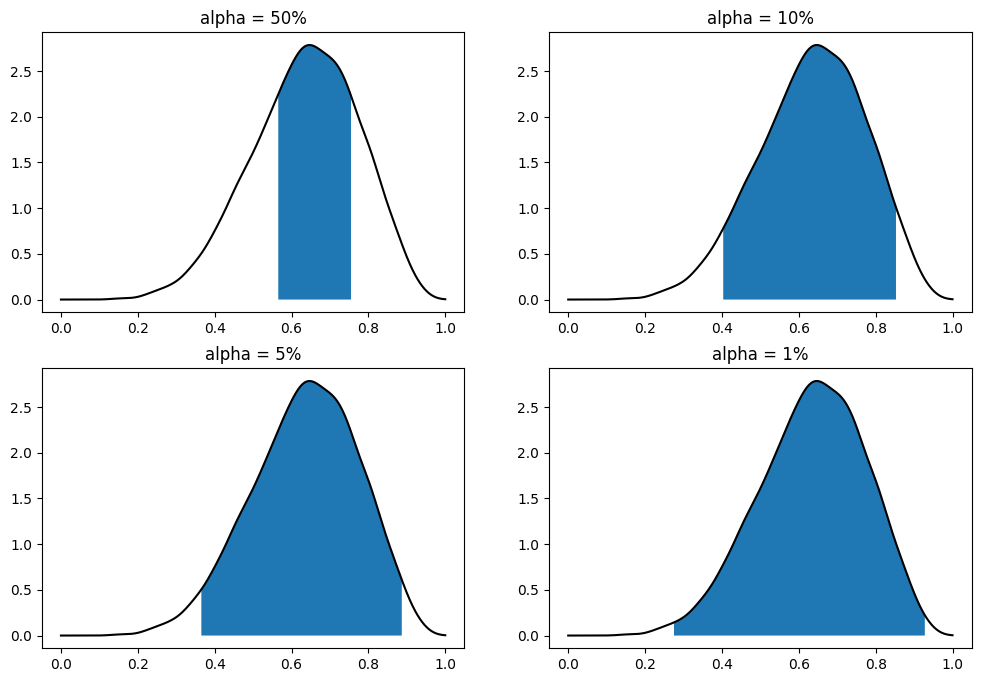

In [49]:
fig, axes = plt.subplots(2,2, figsize = (12,8))
plot_interval(samples,*hpdi(samples, .5),ax = axes[0][0])
plot_interval(samples,*hpdi(samples, .1),ax = axes[0][1])
plot_interval(samples,*hpdi(samples, .05),ax = axes[1][0])
plot_interval(samples,*hpdi(samples, .01),ax = axes[1][1])

axes[0][0].set_title('alpha = 50%')
axes[0][1].set_title('alpha = 10%')
axes[1][0].set_title('alpha = 5%')
axes[1][1].set_title('alpha = 1%')

In [113]:
prob_data = Binominal(p_grid,3).probability(3)
posterior = prob_data * prob_p 
posterior = posterior/posterior.sum()
samples = np.array(random.choices(p_grid, weights =posterior, k = 10000))

(0.7067067067067067, 0.9329329329329329)
(0.8458458458458459, 1.0)


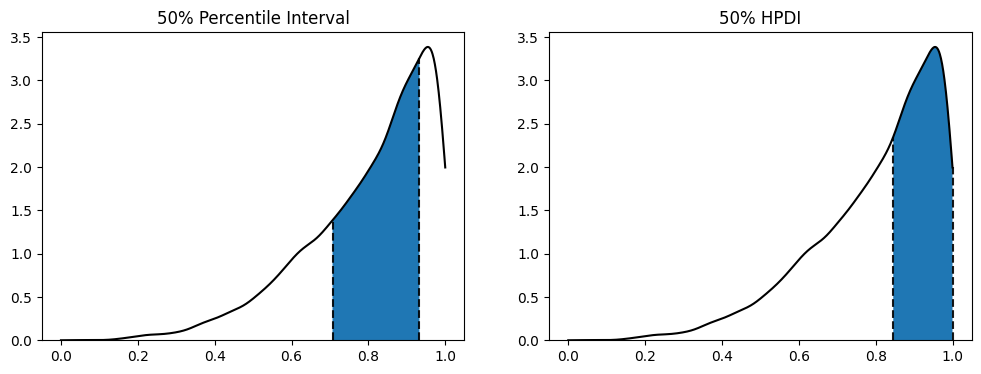

In [106]:
fig, axes = plt.subplots(1,2, figsize = (12,4))
plot_interval(samples,*pi(samples, .5),ax = axes[0])
plot_interval(samples,*hpdi(samples, .5),ax = axes[1])

axes[0].set_title('50% Percentile Interval')
axes[1].set_title('50% HPDI')

print(pi(samples, .5))
print(hpdi(samples, .5))

### 3.2.3. Point estimates 

In [109]:
#map
map = p_grid[posterior.argmax()]
mean = samples.mean()
median = np.quantile(samples ,0.5)

print(f'MAP: {map}')
print(f'Mean: {mean}')
print(f'Median: {median}')

MAP: 1.0
Mean: 0.8022217217217218
Median: 0.8458458458458459


In [127]:
def loss_fn(x):
    return (posterior*np.abs(x - p_grid)).sum()


loss = np.array([loss_fn(x) for x in p_grid])

p_grid[loss.argmin()]


0.8408408408408409

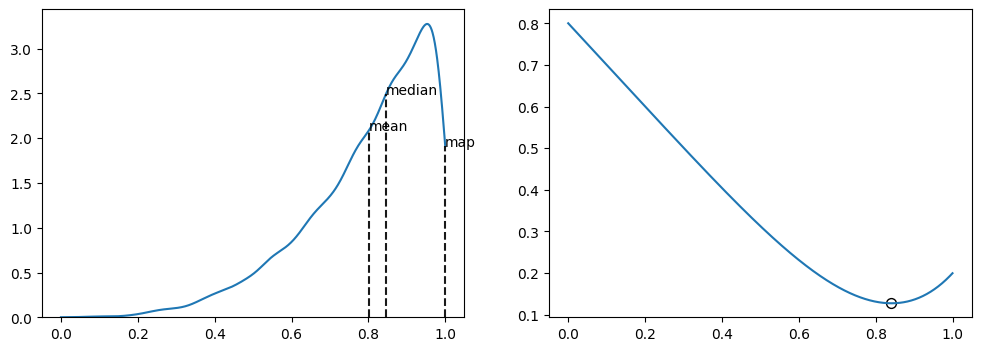

In [145]:
fig, axes = plt.subplots(1,2, figsize = (12,4))
kernel = gaussian_kde(samples,)
axes[0].plot(p_grid, kernel.pdf(p_grid))
axes[1].plot(p_grid,loss ,)
axes[1].scatter(p_grid[loss.argmin()],loss.min() , s = 50, edgecolors = 'k', c = 'white')
axes[0].set_ylim(0)
axes[0].axvline(x = map, ymax= kernel.pdf(map)/axes[0].get_ylim()[1] , ls = '--', c = 'k',alpha = .9)
axes[0].axvline(x = mean, ymax= kernel.pdf(mean)/axes[0].get_ylim()[1] , ls = '--', c = 'k',alpha = .9)
axes[0].axvline(x = median, ymax= kernel.pdf(median)/axes[0].get_ylim()[1] , ls = '--', c = 'k',alpha = .9)
axes[0].text(s = 'map', x = map, y = kernel.pdf(map))
axes[0].text(s = 'mean', x = mean, y = kernel.pdf(mean))
axes[0].text(s = 'median', x = median, y = kernel.pdf(median))
fig.show()